In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import eco2ai
import scipy
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [2]:
tracker = eco2ai.Tracker(project_name="DNL", experiment_description="Training DGD")

C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\emission_track.py:128: UserWarning: 
    If you use a VPN, you may have problems with identifying your country by IP.
    It is recommended to disable VPN or
    manually install the ISO-Alpha-2 code of your country during initialization of the Tracker() class.
    You can find the ISO-Alpha-2 code of your country here: https://www.iban.com/country-codes
    
  warnings.warn(


In [3]:
seed = 42
no_users = 100
lambda_logistic = 1e-3

In [4]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.size)
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

In [5]:
def loss(w, A, b, l2):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg

In [6]:
def gradient(w, A, b, l2):
    m = A.shape[0]
    z = b * np.dot(A, w)
    tmp0 = np.minimum(z, 0)
    tmp1 = np.exp(tmp0 - z) / ((np.exp(tmp0) + np.exp(tmp0 - z)))
    tmp2 = - tmp1 * b
    res = np.dot(A.T, tmp2) / m + l2 * w
    return res

In [7]:
def hessian(w, A, b, l2):
    Aw = A @ w
    activation = scipy.special.expit(Aw)
    weights = activation * (1-activation)
    A_weighted = np.multiply(A.T, weights)
    return A_weighted@A/A.shape[0] + l2*np.eye(A.shape[1])

In [8]:
def generate_graph(n, seed):
    """Generate a random connected graph"""
    while True:
        # g = nx.generators.random_graphs.binomial_graph(n, 0.4, seed = seed) 
        g = nx.random_geometric_graph(n, 0.4, seed = seed)
        #g = nx.grid_2d_graph(int(n/5), int(n/5))
        if nx.algorithms.components.is_connected(g):
            return g

In [9]:
def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)

In [10]:
def metropolis_weights(Adj):
    N = np.shape(Adj)[0]
    degree = degrees(Adj)
    W = np.zeros([N, N])
    for i in range(N):
        N_i = np.nonzero(Adj[i, :])[1]  # Fixed Neighbors
        for j in N_i:
            W[i, j] = 1/(1+np.max([degree[i], degree[j]]))
        W[i, i] = 1 - np.sum(W[i, :])
    return W

1654
100


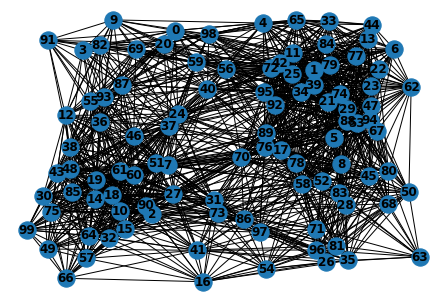

In [11]:
G = generate_graph(no_users, seed)

adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
comm_matrix = metropolis_weights(adjacency_matrix)

print(G.number_of_edges())
print(G.number_of_nodes())
nx.draw(G, with_labels=True, font_weight='bold')

In [12]:
X = np.load('X.npy')
y = np.load('y.npy').ravel()

num_feature = X.shape[1] #+ 1 #+1 for bias

In [13]:
tracker.start()
X, y = random_split(X, y, no_users, seed)

theta = [np.zeros(num_feature) for _ in range(no_users)]


d = [np.zeros(num_feature) for _ in range(no_users)] # direction
lamd = [np.zeros(num_feature) for _ in range(no_users)] # dual variables

C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\tools\tools_cpu.py:240: NoNeededLibrary: 
It's impossible to deretmine cpu number correctly
For now, number of cpu devices is set to 1


  warnings.warn(message="\nIt's impossible to deretmine cpu number correctly\nFor now, number of cpu devices is set to 1\n\n",
C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\tools\tools_gpu.py:35: NoGPUWarning: 

There is no any available GPU devices or your GPU is not supported by Nvidia library!
The tracker will consider CPU usage only

  warnings.warn(message="\n\nThere is no any available GPU devices or your GPU is not supported by Nvidia library!\nThe tracker will consider CPU usage only\n",


In [14]:
print(X[0].shape)

(110, 40)


In [15]:
# Optimal objective function, i.e., f(x*)
obj0 = 0.31939515938637913 # phishing dataset

In [16]:
n_iters = 20
alpha = 0.8

losses_dsgd = []
accuracies_dsgd = []
op_gap_dsgd = np.zeros(shape=[n_iters])
re_dsgd = np.zeros(shape=[n_iters])



for iter in range(n_iters):
    tracker.start()
    
    for i in range(no_users):        
        grad = gradient(theta[i], X[i], y[i], lambda_logistic)
  
        w_neighbors_sum = np.zeros(num_feature)
        w_neighbors_sum = np.add(w_neighbors_sum, comm_matrix[i,i]*theta[i])
        for j in G.neighbors(i):
            w_neighbors_sum = np.add(w_neighbors_sum, comm_matrix[i,j]*theta[j])
        
        theta[i] = w_neighbors_sum - alpha*grad
  

    theta_avg = 1/no_users*sum(theta)
    
    loss_dsgd = np.mean([loss(theta_avg, X[i], y[i], lambda_logistic) for i in range(no_users)])
    losses_dsgd.append(loss_dsgd)
  
    op_gap_dsgd[iter] = np.abs(losses_dsgd[-1] - obj0)
    tracker.stop()

# Optimality Gap

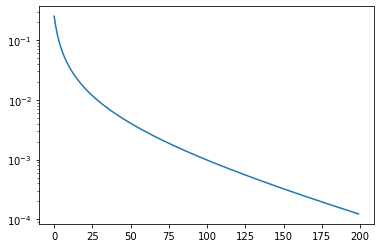

In [17]:
import matplotlib.pyplot as plt
plt.semilogy(op_gap_dsgd)
np.save('op_gap_dsgd', op_gap_dsgd)

In [18]:
import pandas as pd

emission = pd.read_csv('dgd_emission.csv')

In [19]:
emission.head()

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
0,99ac6d12-1487-4e15-8edd-57e765948084,DNL,training DNL,NaN,2022-10-04 12:32:46,10.679456,2.160146e-08,3.064815e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
1,a8217c81-0e06-4caf-902b-c0530a71ac86,DNL,training DNL,NaN,2022-10-04 12:39:10,11.452991,2.813663e-08,3.992025e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
2,651ab67f-bdc1-4c4b-add0-8b0224089f91,DNL,training DNL,NaN,2022-10-04 12:43:03,11.146560,3.438618e-08,4.878711e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
3,8b2c655f-6c02-4b47-af9a-0e8217f04ac9,DNL,Training DGD,NaN,2022-10-04 12:53:21,14.888129,1.427918e-07,2.025930e-08,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
